# **Rossmann Store Sales Prediction**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Here we are predicting 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/4594/media/rossmann_banner2.png)

# **Data Exploration and Engineering**

First, we will mount my google drive and load data into the googlecolab workspace.

In [2]:
# import necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
#import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_path = "./Hari-Assignment/data"

store = pd.read_csv(data_path+"/store.csv",sep=',',dtype= {'StoreType':str,
                                                          'Assortment':str,
                                                          'PromoInterval':str})

train = pd.read_csv(data_path+"/train.csv",sep= ',', parse_dates=['Date'], dtype= {'StateHoliday': str, 'SchoolHoliday':str} )
test =  pd.read_csv(data_path+"/test.csv",sep= ',', parse_dates=['Date'], dtype= {'StateHoliday': str, 'SchoolHoliday':str} )

**Cleaning Train dataset**

In [5]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month



In [6]:
def factor_to_integer(df, colname, start_value=0):
    while df[colname].dtype == object:
        myval = start_value # factor starts at "start_value".
        for sval in df[colname].unique():
            df.loc[df[colname] == sval, colname] = myval
            myval += 1
        df[colname] = df[colname].astype(int, copy=False)
    print('levels :', df[colname].unique(), '; data type :', df[colname].dtype)

In [7]:
factor_to_integer(train, 'SchoolHoliday')
factor_to_integer(train, 'StateHoliday')

levels : [0 1] ; data type : int32
levels : [0 1 2 3] ; data type : int32


Check for number of NaNs for selected columns.

In [8]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : train[colname].isnull().sum() for colname in train.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Sales', 0),
 ('Customers', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Year', 0),
 ('Month', 0)]

**Cleaning Test dataset**

In [9]:
test['Year'] = pd.DatetimeIndex(test['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month

In [10]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Open', 11),
 ('Id', 0),
 ('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Year', 0),
 ('Month', 0)]

There are 11 missing values in Open column. Let’s have a detailed look at those:

In [11]:
test.loc[np.isnan(test['Open'])]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
479,480,622,4,2015-09-17,NaN,1,0,0,2015,9
1335,1336,622,3,2015-09-16,NaN,1,0,0,2015,9
2191,2192,622,2,2015-09-15,NaN,1,0,0,2015,9
3047,3048,622,1,2015-09-14,NaN,1,0,0,2015,9
4759,4760,622,6,2015-09-12,NaN,0,0,0,2015,9
5615,5616,622,5,2015-09-11,NaN,0,0,0,2015,9
6471,6472,622,4,2015-09-10,NaN,0,0,0,2015,9
7327,7328,622,3,2015-09-09,NaN,0,0,0,2015,9
8183,8184,622,2,2015-09-08,NaN,0,0,0,2015,9
9039,9040,622,1,2015-09-07,NaN,0,0,0,2015,9


Do we have any information about store 622? Check train dataset

In [12]:
train.loc[np.where(train['Store']==622)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
621,622,5,2015-07-31,6306,540,1,1,0,0,2015,7
1736,622,4,2015-07-30,5412,406,1,1,0,0,2015,7
2851,622,3,2015-07-29,5326,468,1,1,0,0,2015,7
3966,622,2,2015-07-28,4966,417,1,1,0,0,2015,7
5081,622,1,2015-07-27,5413,517,1,1,0,0,2015,7


As we have information about store 622 in train dataset as open (1) lets replace the NaN from test dataset to open (1)

In [13]:
test.loc[np.isnan(test['Open']),'Open']=1

Checking for missing values in test dataset

In [14]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Id', 0),
 ('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Year', 0),
 ('Month', 0)]

In [15]:
factor_to_integer(test, 'StateHoliday')
factor_to_integer(test, 'SchoolHoliday')

levels : [0 1] ; data type : int32
levels : [0 1] ; data type : int32


because only StateHoliday 0 and 1 exist in test dataset, we should consider deleting the rows in train dataset that the StateHoliday value is different than 0 or 1.


In [16]:
train.loc[train['StateHoliday'] > 1].shape

(10790, 11)

In [17]:
train = train.loc[train['StateHoliday']<2]

**Cleaning Store Dataset**

In [18]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Promo2SinceWeek', 544),
 ('Promo2SinceYear', 544),
 ('PromoInterval', 544),
 ('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0)]

In [19]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

If there is no promotion, then the corresponding columns should have zero values.

In [20]:
store.loc[store['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

In [21]:
store.loc[np.where(store['Promo2']!=0)].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [22]:
store.loc[store['Promo2'] != 0, 'Promo2SinceWeek'] = store['Promo2SinceWeek'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceWeek']
store.loc[store['Promo2'] != 0, 'Promo2SinceYear'] = store['Promo2SinceYear'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceYear']

In [23]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [24]:
factor_to_integer(store, 'PromoInterval', start_value=0)

levels : [0 1 2 3] ; data type : int32


In [25]:
factor_to_integer(store, 'StoreType')
factor_to_integer(store, 'Assortment')

levels : [0 1 2 3] ; data type : int32
levels : [0 1 2] ; data type : int32


Are there still missing values?

In [26]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

Filling the missing values with sklearn’s built-in command. Filling with the column.median().

In [27]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer( strategy='median').fit(store)
store_imputed = imp.transform(store)
store2 = pd.DataFrame(store_imputed, columns=store.columns.values)

In [28]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store2[colname].isnull().sum() for colname in store2.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('CompetitionDistance', 0),
 ('CompetitionOpenSinceMonth', 0),
 ('CompetitionOpenSinceYear', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [29]:
store2['CompetitionOpenSinceMonth'] = store2['CompetitionOpenSinceMonth'].max() - store2['CompetitionOpenSinceMonth']
store2['CompetitionOpenSinceYear'] = store2['CompetitionOpenSinceYear'].max() - store2['CompetitionOpenSinceYear']


In [30]:
store2.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111.0,1.0,0.0,1900.0,6.0,1.0,1.0,19.0,2.0,1.0
1111,1112.0,0.0,1.0,1880.0,8.0,9.0,0.0,0.0,0.0,0.0
1112,1113.0,1.0,1.0,9260.0,4.0,5.0,0.0,0.0,0.0,0.0
1113,1114.0,1.0,1.0,870.0,4.0,5.0,0.0,0.0,0.0,0.0
1114,1115.0,2.0,1.0,5350.0,4.0,5.0,1.0,28.0,3.0,3.0


In [31]:
train_store = pd.merge(train, store2, how = 'left', on='Store')
test_store = test.reset_index().merge(store2, how = 'left', on='Store').set_index('Id')

Visual Exploration

In [32]:
import seaborn as sns
sns.distplot(train_store['Sales'])

ModuleNotFoundError: No module named 'seaborn'

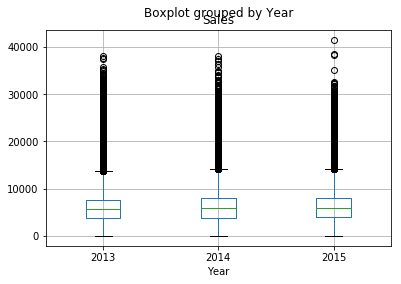

In [33]:
train_store.boxplot(column='Sales', by='Year')
plt.show()

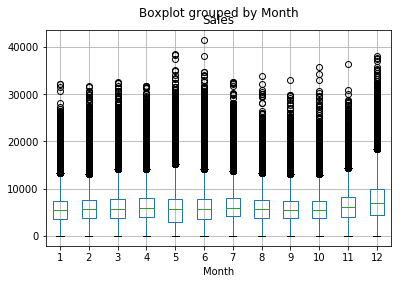

In [34]:
train_store.boxplot(column='Sales', by='Month')
plt.show()

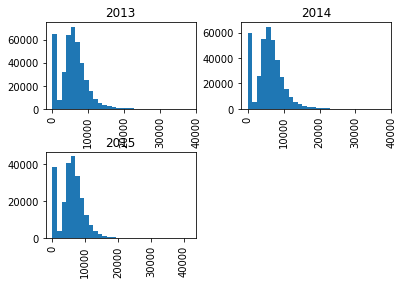

In [35]:
train_store.hist(column='Sales', by='Year', bins=30)
plt.show()

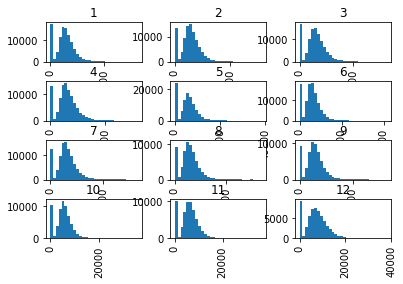

In [36]:
train_store.hist(column='Sales', by='Month', bins=30)
plt.show()

# Modeling

In [37]:
print(train_store.columns.values)
print(test_store.columns.values)

['Store' 'DayOfWeek' 'Date' 'Sales' 'Customers' 'Open' 'Promo'
 'StateHoliday' 'SchoolHoliday' 'Year' 'Month' 'StoreType' 'Assortment'
 'CompetitionDistance' 'CompetitionOpenSinceMonth'
 'CompetitionOpenSinceYear' 'Promo2' 'Promo2SinceWeek' 'Promo2SinceYear'
 'PromoInterval']
['index' 'Store' 'DayOfWeek' 'Date' 'Open' 'Promo' 'StateHoliday'
 'SchoolHoliday' 'Year' 'Month' 'StoreType' 'Assortment'
 'CompetitionDistance' 'CompetitionOpenSinceMonth'
 'CompetitionOpenSinceYear' 'Promo2' 'Promo2SinceWeek' 'Promo2SinceYear'
 'PromoInterval']


In [38]:
train_model = train_store.drop(['Customers', 'Date'], axis=1)
train_model['Year'] = train_model['Year'].max() - train_model['Year']
#print(train_model.head())

## Linear Modeling

**Is the relationship significant?**

Correlation is any of a broad class of statistical relationships involving dependence

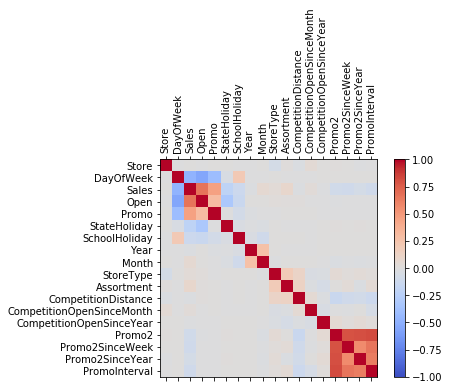

In [39]:
import matplotlib.pyplot as plt

corr = train_model.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_model.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_model.columns)
ax.set_yticklabels(train_model.columns)
plt.show()

In [40]:
print(corr["Sales"].sort_values(ascending=False))

Sales                        1.000000
Open                         0.669017
Promo                        0.457941
Assortment                   0.090303
Month                        0.055052
StoreType                    0.037322
CompetitionOpenSinceMonth    0.024011
Store                        0.005271
CompetitionOpenSinceYear    -0.010273
CompetitionDistance         -0.019023
Year                        -0.023087
Promo2SinceYear             -0.066596
Promo2                      -0.092353
PromoInterval               -0.094013
Promo2SinceWeek             -0.097373
SchoolHoliday               -0.121029
StateHoliday                -0.207833
DayOfWeek                   -0.474969
Name: Sales, dtype: float64


**AIC & BIC **

The Akaike’s information criterion – AIC and the Bayesian information criterion – BIC are measures of the goodness of fit of an estimated statistical model and can also be used for model selection. Both criteria depend on the maximized value of the likelihood function L for the estimated model.

k= # of variables

n = number of observations

AIC= 2k - 2ln(sse)

BIC = n*ln(sse/n) + k*ln(n)


In [41]:

def calAIC(y,y_hat,k):
  resid = y - y_hat
  sse = sum(resid**2)
  AIC= 2*k - 2*np.log(sse)
  return AIC
  
def calBIC(y,y_hat,k):
  n = len(y)
  resid = y - y_hat
  sse = sum(resid**2)
  BIC = n*np.log(sse/n) + k*np.log(n)
  return BIC

##**Building Linear Models**

In [42]:
from sklearn.model_selection import train_test_split
#Creating the features 

features = train_model.drop('Sales', axis=1)
target = train_model['Sales']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(704493, 17)
(301926, 17)
(704493,)
(301926,)


###**Multi Linear Model with scaling**

In [44]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score


#Setting up the scaling pipeline 

pipeline_order = [('scaler', StandardScaler()), ('linear_reg', linear_model.LinearRegression())]

Model_Pipeline = Pipeline(pipeline_order)

# evaluate pipeline
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(Model_Pipeline, X_train, y_train, cv=kfold,scoring= 'r2')
Model_Pipeline.fit(X_train, y_train)
preds_train = Model_Pipeline.predict(X_train)
preds = Model_Pipeline.predict(X_test)
print("Train R^2:",round(results.mean(),3), round(results.std(),3))
print("Train AIC, BIC :",round(calAIC(y_train,preds_train,len(X_train.columns)),3),",", round(calBIC(y_train,preds_train,len(X_train.columns))))
print("-----------------------------------------------")
print("Test R^2:",round(r2_score(y_test, preds),3))
print("Test AIC, BIC :",round(calAIC(y_test,preds,len(X_test.columns)),3),",", round(calBIC(y_test,preds,len(X_test.columns))))



Train R^2: 0.549 0.0
Train AIC, BIC : -24.334 , 11062074.0
-----------------------------------------------
Test R^2: 0.548
Test AIC, BIC : -22.639 , 4740909.0


###**Multi Linear model without scaling**

In [45]:
from sklearn import linear_model
#Initializing a linear regression model 

linear_reg = linear_model.LinearRegression()

#Fitting the model on the data

model_wos = linear_reg.fit(X_train, y_train)

#Accuracy of the model
preds = model_wos.predict(X_test)
print("Test R^2:",round(r2_score(y_test, preds),3))
print("Test AIC, BIC :",round(calAIC(y_test,preds,len(X_test.columns)),3),",", round(calBIC(y_test,preds,len(X_test.columns))))

Test R^2: 0.548
Test AIC, BIC : -22.639 , 4740909.0


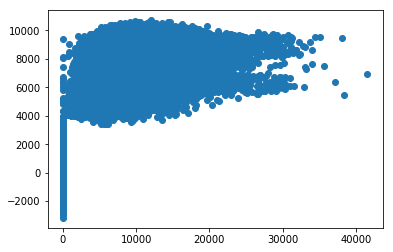

In [46]:
plt.scatter(y_test,linear_reg.predict(X_test))

###**Cross validation with K-Fold**

### **Linear Model using SGD**

In [47]:
pipeline_order_sgd = [('scaler', StandardScaler()), ('linear_reg', linear_model.SGDRegressor())]

Model_Pipeline_sgd = Pipeline(pipeline_order_sgd)

# evaluate pipeline
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(Model_Pipeline_sgd, X_train, y_train, cv=kfold,scoring= 'r2')
Model_Pipeline_sgd.fit(X_train, y_train)
preds_train = Model_Pipeline_sgd.predict(X_train)
preds = Model_Pipeline_sgd.predict(X_test)
print("Train R^2:",round(results.mean(),3), round(results.std(),3))
print("Train AIC, BIC :",round(calAIC(y_train,preds_train,len(X_train.columns)),3),",", round(calBIC(y_train,preds_train,len(X_train.columns))))
print("-----------------------------------------------")
print("Test R^2:",round(r2_score(y_test, preds),3))
print("Test AIC, BIC :",round(calAIC(y_test,preds,len(X_test.columns)),3),",", round(calBIC(y_test,preds,len(X_test.columns))))


Train R^2: 0.548 0.0
Train AIC, BIC : -24.341 , 11064435.0
-----------------------------------------------
Test R^2: 0.547
Test AIC, BIC : -22.645 , 4741888.0


## **Part C: Multi-Colinearity and stepwise regression**

## **Part E: Regularization**

In [48]:
train_model.head(5)

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,1,1,0,0,0,7,0.0,0.0,1270.0,3.0,7.0,0.0,0.0,0.0,0.0
1,2,5,6064,1,1,0,0,0,7,1.0,0.0,570.0,1.0,8.0,1.0,37.0,5.0,1.0
2,3,5,8314,1,1,0,0,0,7,1.0,0.0,14130.0,0.0,9.0,1.0,36.0,4.0,1.0
3,4,5,13995,1,1,0,0,0,7,0.0,1.0,620.0,3.0,6.0,0.0,0.0,0.0,0.0
4,5,5,4822,1,1,0,0,0,7,1.0,0.0,29910.0,8.0,0.0,0.0,0.0,0.0,0.0


In [49]:
train_model['MeanSalesStore'] = train_model.groupby('Store')['Sales'].transform('mean')

In [50]:
train_model = train_model[train_model['Sales']>0]

In [51]:
train_model['CrossedMeanSales'] = np.where(train_model['Sales'] >= train_model['MeanSalesStore'], 1,0 )

In [52]:
train_model.to_csv('train_model_classification.csv')